<a href="https://colab.research.google.com/github/Jack3690/INSIST/blob/main/notebooks/Light_curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/Jack3690/INSIST --quiet
!pip install git+https://github.com/Srivardini/tara --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.9/195.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.9/206.9 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 7.2 MB/s eta 0:00:00


In [2]:
import pista as pt
from pista.utils import Xmatch, generate_psf
import matplotlib.pyplot as plt
import matplotlib.colors as col
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
from astropy.table import Table, vstack
from astropy.modeling.fitting import LevMarLSQFitter
from PIL import Image, ImageDraw
import cv2
import imageio
from glob import glob
from scipy.stats import skewnorm
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.io import fits

In [3]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
data_path = pt.data_dir

In [5]:
def light_curve(x, y, cadence):
  x_new = np.arange(x[0], x[-1], cadence)
  y_new = np.interp(x_new, x, y)
  return x_new, y_new

In [6]:
start = 0
end = 20*60

num_points = 1000

x_in = np.arange(start, end, 1)
y_in = skewnorm.pdf(x_in, 10, loc=400, scale=3*60)

t,dmag = light_curve(x_in, y_in, 0.1)
dmag = -dmag/dmag.max()

In [7]:
x_in = np.arange(0, len(y_in), 1)
t,dmag = light_curve(x_in, y_in, 0.1)
dmag /= dmag.max()
len(dmag)

11990

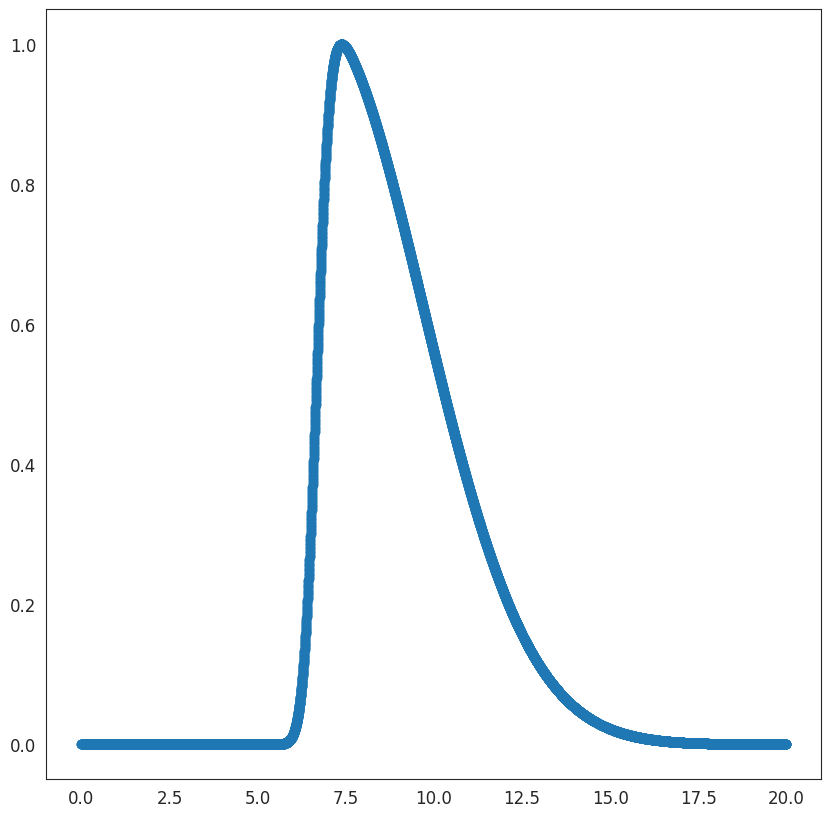

In [8]:
plt.plot(t/60,dmag,'o')

In [174]:
fwhm = 3
sigma = fwhm*gaussian_fwhm_to_sigma

In [175]:
params = {
          'sigma_x' : sigma,
          'sigma_y' : sigma,
}

In [176]:
psf = generate_psf(201, params, 'Gaussian' )

In [177]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [167]:
3.3e-6*3.3e-6/1e-4

1.089e-07

In [168]:
tel_params ={
            'aperture'       : 11*2.5,
            'pixel_scale'    : 1.25,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [],
             'coeffs'       : 2e-2,
             'theta'        : 0,
              'M_sky'      : 18,
            }

In [169]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],# [f'{data_path}/INSIST/UV/QE.dat,1,100'],
              'qe_mean'    : 0.95,
              'G1'         : 0.885009765625*68,
              'FWC'        : 58e3,
              'bit_res'    : 16,
              'bias'       : 20,
              'DFM'        : 0.01424,
              'PRNU_frac'  :  0.25/100,
              'pixel_area' : 1.089e-07,
              'DCNU'       :  0.1/100,
              'RN'         :  3.4,
              'T'          :  275,
              'DN'         :  0.01/100
              }

# **Example 1**

In [193]:
ra = np.random.uniform(10, 10+ 200/3600,5)
dec = np.random.uniform(10, 10 + 200/3600,5)
mag = np.random.uniform(10,11,5)
df = pd.DataFrame(zip(ra, dec, mag), columns = ['ra', 'dec', 'mag'])

In [ ]:
tabs = []
for i in range(len(dmag)):
  #df['ra'] = x #+ np.random.uniform(-10,10,1)[0]
  #df['dec'] = y #+ np.random.uniform(-10,10,1)[0]
  df['mag'][0] =  10 - dmag[i]

  sim = pt.Imager(df = df,tel_params = tel_params, exp_time = 0.1, plot = False,
             n_x = 300, n_y = 300)

  sim(det_params = det_params, photometry = 'Aper', detect_sources=False,
        fwhm=2)
  tabs.append(sim.phot_table[sim.phot_table['mag_in']==10 - dmag[i]])
  sim.writecomp(f'/content/output/{i}_sim.fits')

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

Response functions not provided. Using default values


  0%|          | 0/5 [00:00<?, ?it/s]

In [195]:
sim.zero_flux*pow(10,-11/2.5)/sim.gain

7836.3685952806645

(<Figure size 1500x1000 with 2 Axes>,
 <WCSAxes: title={'center': 'Digital \nRequested center :  RA : 10.033 degrees, Dec : 10.018 degrees'}>)

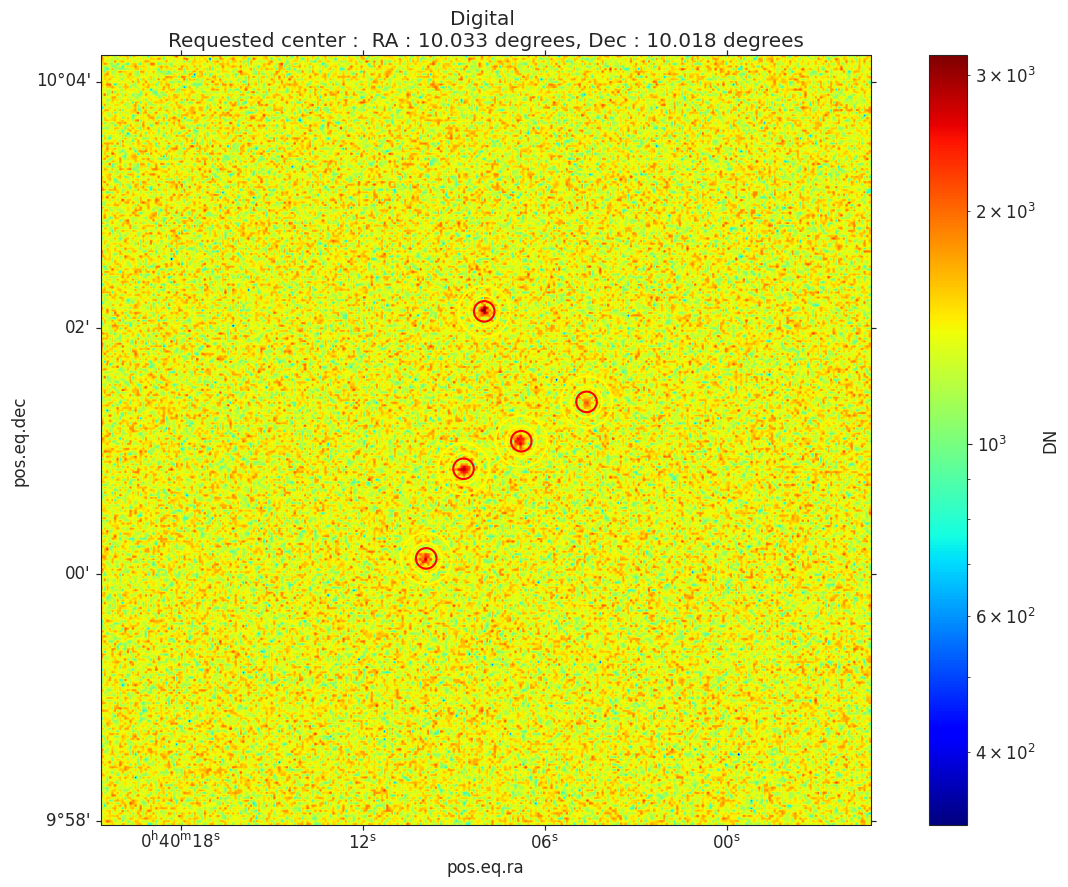

In [196]:
sim.show_image(overlay_apertures=True)

In [188]:
sim.phot_table

id,xcenter,ycenter,aperture_sum,sky_flux,flux,flux_err,SNR,ra,dec,mag_in,mag_out,mag_err
,pix,pix,,electron,electron,electron,,,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,257.61150564458273,99.03419413170583,88632.28083071717,1037.8343730917811,265.5815214775889,43.4709959250021,6.109395835691935,10.007641023438536,10.005212762538124,10.0,10.09352022050488,0.17710425533058546
2,127.8446111538243,114.30981194036124,84979.79333859187,1048.1831488918415,201.51969432274495,42.84873901711421,4.703048419750602,10.053394913091513,10.01051890262456,10.42699820158164,10.393221117647364,0.23006354675323062
3,137.56671455418038,149.00007000269298,79989.66911518677,1026.7463990202875,149.57226443834134,41.98369035233573,3.56262784865028,10.049967145526237,10.022564189751353,10.640128146829266,10.716887185276633,0.30370839895890933
4,149.0,226.6584102737034,78463.92708747626,1037.8343730917811,116.04690760639915,41.715619051386014,2.7818574971511407,10.045935732530587,10.049528913550043,10.375942662412454,10.992430927068277,0.38894875136776785
5,159.2248673718547,174.09114628987362,89686.6345218489,1041.5303644489454,277.3907314605972,43.64897121412739,6.355034809407309,10.042330314719743,10.03127637379985,10.025417630289219,10.046284992542466,0.17025870549101066


In [105]:
sim.det_params

{'shot_noise': 'Poisson',
 'qe_response': [],
 'qe_mean': 1,
 'bias': 50,
 'G1': 3.5400390625,
 'bit_res': 14,
 'RN': 3.4,
 'PRNU_frac': 0.0025,
 'T': 275,
 'DFM': 0.01424,
 'pixel_area': 1.089e-07,
 'DCNU': 0.001,
 'DNFP': 0.0,
 'NF': 0.0,
 'FWC': 58000.0,
 'C_ray_r': 0.04,
 'DN': 0.001}

In [ ]:
sim.dark_frame.max()

0

In [ ]:
tab_t = vstack(tabs)

In [ ]:
tab_t.write('/content/Phot_table.fits', overwrite=True)

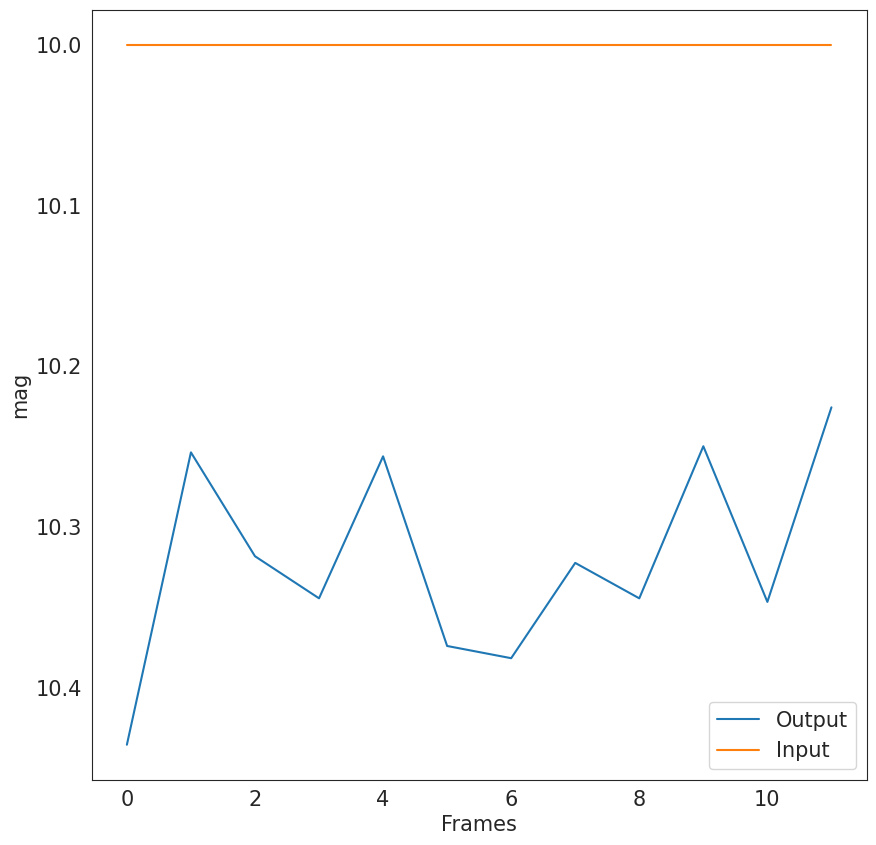

In [ ]:
fig, ax = plt.subplots()
ax.plot(tab_t['mag_out'])
ax.plot(tab_t['mag_in'])
ax.set_xlabel('Frames')
ax.set_ylabel('mag')
ax.invert_yaxis()
plt.legend(['Output','Input'])

# **TARA**

In [ ]:
import tara
from tara.utils import gen_plot

In [ ]:
exps = glob('/content/output/*.fits')

In [ ]:
exps = sorted(exps, key=lambda x: int(x.split('/')[-1].split('_')[0]))

In [ ]:
tar_obj = tara.tara(exps, '/content/tar_out')

-------------------------------------------------
Input directory contains 12 '.fits' 'files
Image shape: (300, 300)
-------------------------------------------------


(<Figure size 700x700 with 1 Axes>,
 <Axes: >,
 <QTable length=8>
   id       xcenter       ...      flux_err             SNR        
              pix         ...                                      
 int64      float64       ...      float64            float64      
 ----- ------------------ ... ------------------ ------------------
     1  234.9895539950824 ...  5187.407012576626  2.495070918831078
     2  179.8525695792699 ...  5151.632689691795  1.696589685803146
     3  283.3363813970518 ... 5185.6691164306785  1.634828505846316
     4  77.28364733855588 ...  5199.149752793518  2.389555327225602
     5 176.10669649979184 ...  5178.216784512225 0.4158231548589039
     6 186.80076456110908 ...  5171.615859725811  1.477635634696344
     7 148.60681054730662 ...  5181.093241412166 0.7023547121631496
     8 106.27786419121752 ... 4697.9726685465075 16.020917031348212)

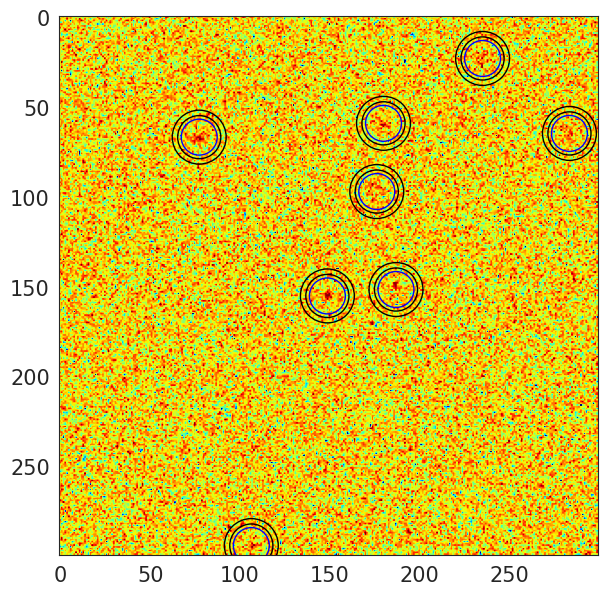

In [ ]:
tar_obj.show_image(th=0.5)